In [1]:
!ls ../data/30measures/

LP_backing_clean.wav
LP_backing_crunch.wav
LP_backing_distorted.wav
LP_backing_raw.wav
LP_lead_clean.wav
LP_lead_crunch.wav
LP_lead_distorted.wav
LP_lead_raw.wav
ST_backing_clean.wav
ST_backing_crunch.wav
ST_backing_distorted.wav
ST_backing_raw.wav
ST_lead_clean.wav
ST_lead_crunch.wav
ST_lead_distorted.wav
ST_lead_raw.wav


In [4]:
!pip install pydub
from pydub import AudioSegment
import matplotlib.pyplot as plt
import numpy as np

C:\Users\johann\Anaconda3\envs\wingpu\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [5]:
LP_backing_raw = AudioSegment.from_file('../data/30measures/LP_backing_raw.wav', 'wav')

In [6]:
LP_backing_raw_sample = np.array(LP_backing_raw.get_array_of_samples())

In [7]:
LP_backing_raw_sample.shape

(5242614,)

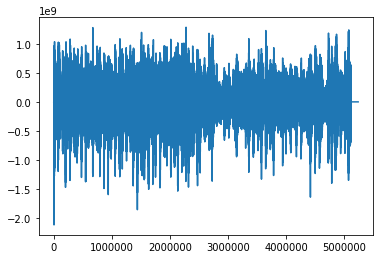

In [8]:
plt.plot(LP_backing_raw_sample)

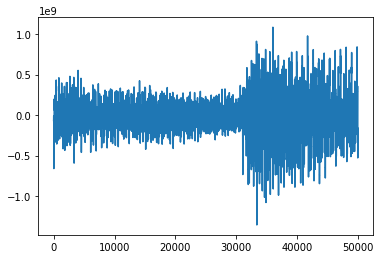

In [8]:
r_idx = np.random.choice(LP_backing_raw_sample.shape[0] - 50000)
LP_backing_raw_frag = LP_backing_raw_sample[r_idx: r_idx + 50000]
plt.plot(LP_backing_raw_frag)

In [10]:
# Data loader, processor, augmentation
%matplotlib inline
import matplotlib.pyplot as plt
import pathlib
from pydub import AudioSegment
import numpy as np
from datetime import datetime

sounds = []
g_class = [] # Stratocaster: 0, Les Paul: 1
f_names = []
datas = []
specs = []
waves = []
d_names = []

for f_name in pathlib.Path('../data/30measures/').iterdir():
  
    # Data Selector
    if('backing_raw' not in f_name.name): continue
  
    print(str(f_name.name.split('/')[-1]) + ' ... now processing')
    
    sounds.append(AudioSegment.from_file('../data/30measures/' + f_name.name, 'wav'))
    datas.append(np.array(AudioSegment.from_file('../data/30measures/' + f_name.name, 'wav').get_array_of_samples()))
    
    # Augmentation
    
    for i in range(1000):
        g_class.append(int('LP_' in f_name.name))
        d_names.append(('_' + str(i) + '.').join(f_name.name.split('.')))
        
        r_idx = np.random.choice(datas[-1].shape[0] - 50000)

        data = datas[-1][r_idx: r_idx + 50000]
        waves.append(data)
        sampling_rate = 48000
        NFFT = 1024 
        OVERLAP = NFFT / 2 
        frame_length = data.shape[0] 
        split_number = len(np.arange((NFFT / 2), frame_length, (NFFT - OVERLAP))) 

        window = np.hamming(NFFT)  

        spec = np.zeros([split_number, NFFT // 4]) 


        pos = 0

        for fft_index in range(split_number):
            frame = data[int(pos):int(pos+NFFT)]
            if len(frame) == NFFT:
                windowed = window * frame  
                fft_result = np.fft.rfft(windowed)

                fft_data2 = np.real(fft_result[:int(len(fft_result)/2)]) 
                fft_data2 = np.log(fft_data2** 2)  

                for i in range(len(spec[fft_index])):
                    spec[fft_index][-i-1] = fft_data2[i]

                pos += (NFFT - OVERLAP)

        specs.append(spec.T)

g_class = np.eye(2)[g_class]
print('\nfine')

LP_backing_raw.wav ... now processing


C:\Users\johann\Anaconda3\envs\wingpu\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log


ST_backing_raw.wav ... now processing

fine


In [ ]:
# Network
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def tf_log(x):
    return tf.log(tf.clip_by_value(x, 1e-10, x))

tf.reset_default_graph()

is_training = tf.placeholder(tf.bool, shape=())

x = tf.placeholder(shape=[None, 256, 97, 1], dtype=tf.float32)
t = tf.placeholder(tf.float32, [None, 2])

h = tf.keras.layers.Conv2D(filters=32, kernel_size= [3, 3], kernel_initializer = tf.contrib.layers.variance_scaling_initializer())(x) 
h = tf.keras.layers.BatchNormalization()(h, training=is_training)
h = tf.nn.relu(h)
h = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(h) 

h = tf.keras.layers.Conv2D(filters=64, kernel_size= [3, 3], kernel_initializer = tf.contrib.layers.variance_scaling_initializer())(h) 
h = tf.keras.layers.BatchNormalization()(h, training=is_training)
h = tf.nn.relu(h)
h = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(h) 

h = tf.keras.layers.Conv2D(filters=128, kernel_size= [3, 3], kernel_initializer = tf.contrib.layers.variance_scaling_initializer())(h) 
h = tf.keras.layers.BatchNormalization()(h, training=is_training)
h = tf.nn.relu(h)
h = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(h) 

h = tf.keras.layers.Flatten()(h)
h = tf.keras.layers.Dense(units=256, activation=tf.nn.relu)(h)
y = tf.keras.layers.Dense(units=2, activation=tf.nn.softmax)(h)

cost = - tf.reduce_mean(tf.reduce_sum(t * tf_log(y), axis = 1))

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(0.00001).minimize(cost)

In [ ]:
x_train, x_test, t_train, t_test = train_test_split(specs, g_class, test_size = 0.2, random_state = 42)

x_train = np.array(x_train) / np.array(x_train).max()
x_test = np.array(x_test) / np.array(x_test).max()
t_train = np.array(t_train)
t_test = np.array(t_test)

print(x_train.shape)
print(x_test.shape)
print(t_train.shape)
print(t_test.shape)


In [ ]:
x_train, x_test, t_train, t_test = train_test_split(specs, g_class, test_size = 0.2)

x_train = np.array(x_train) / np.array(x_train).max()
x_test = np.array(x_test) / np.array(x_test).max()
t_train = np.array(t_train)
t_test = np.array(t_test)



for _ in range(10):
    n_epochs = 100
    batch_size = 512
    n_batches = x_train.shape[0] // batch_size
    errflag = False

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    for epoch in range(n_epochs):
        x_train, t_train = shuffle(x_train, t_train)
        for batch in range(n_batches):
            start = batch * batch_size
            end = start + batch_size
            sess.run(optimizer, feed_dict={x: x_train[start:end][:, :, :, None], t: t_train[start:end], is_training: True})

        if epoch % 10 == 0:
            y_pred, cost_test = sess.run([y, cost], feed_dict={x: x_test[:, :, :, None], t: t_test, is_training: False})
            print('EPOCH: {}, Test Cost: {:.3f}, Test Accuracy: {:.3f}'.format(
                epoch,
                cost_test,
                accuracy_score(t_test.argmax(axis=1), y_pred.argmax(axis=1))
            ))
            print(np.sum(t_test.argmax(axis = 1) == 1), np.sum(y_pred.argmax(axis = 1) == 1))

        if epoch == 0 and (np.sum(np.sum(y_pred.argmax(axis = 1) == 1) == 0 or np.sum(y_pred.argmax(axis = 1) == 1) == t_test.shape[0])):
            errflag = True
            break

    if(not errflag):
        saver = tf.train.Saver()
        saver.save(sess, '../model/model' + str(datetime.now()))

    sess.close()
    print('fine')
    print()

In [11]:
len(waves)

2000

ST_backing_raw_291.wav


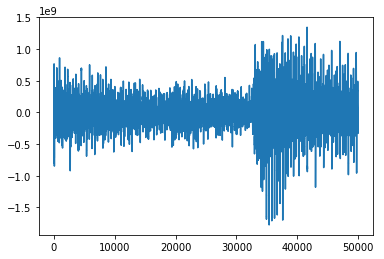

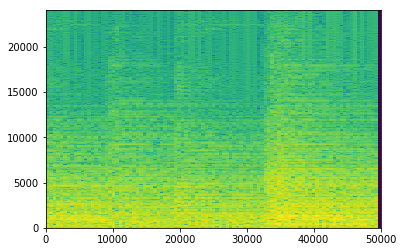

LP_backing_raw_710.wav


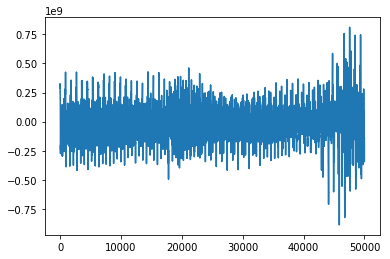

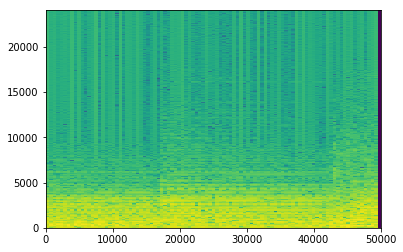

ST_backing_raw_603.wav


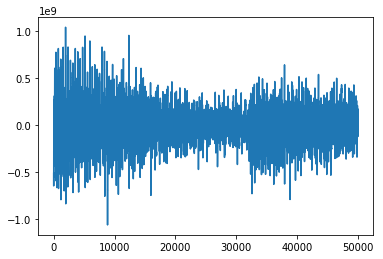

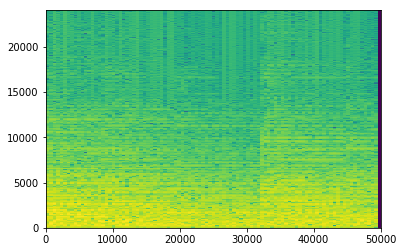

ST_backing_raw_673.wav


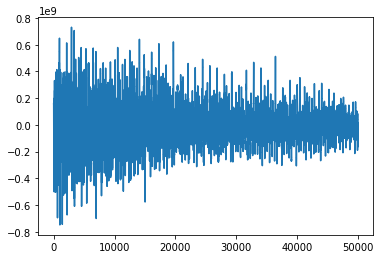

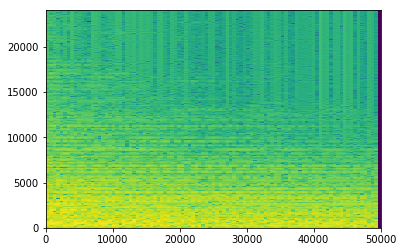

LP_backing_raw_833.wav


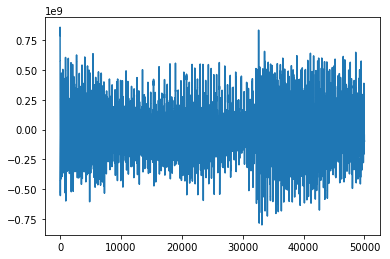

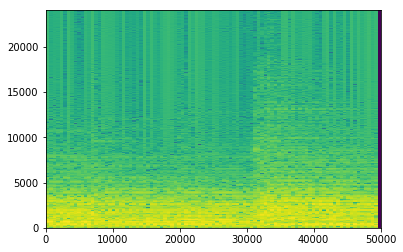

In [12]:
for _ in range(5):
    i = np.random.choice(len(waves))
    print(d_names[i])
    plt.plot(waves[i])
    plt.show()
    plt.imshow(specs[i], extent=[0, frame_length, 0, sampling_rate/2], aspect="auto")
    plt.show()

In [13]:
specs[0].shape

(256, 97)

In [14]:
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


x_train, x_test, t_train, t_test = train_test_split(specs, g_class, test_size = 0.2, random_state = 42)

x_train = np.array(x_train) / np.array(x_train).max()
x_test = np.array(x_test) / np.array(x_test).max()
t_train = np.array(t_train)
t_test = np.array(t_test)

print(x_train.shape)
print(x_test.shape)
print(t_train.shape)
print(t_test.shape)


(1600, 256, 97)
(400, 256, 97)
(1600, 2)
(400, 2)


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten

In [19]:
model = Sequential()

model.add(Conv2D(32, kernel_size=2, activation='relu', input_shape=(256,97,1)))
model.add(Conv2D(32, kernel_size=2, activation='relu'))
#model.add(Conv2D(16, kernel_size=2, activation='relu'))
model.add(Flatten())

#model.add(Dense(units = 256))
model.add(Dense(units = 128))

model.add(Activation('relu'))
model.add(Dense(units = 2))
model.add(Activation('softmax'))

In [20]:
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = 'adam', 
    metrics = ['accuracy']
)

In [ ]:
model.fit(
    x_train.reshape((1600, 256, 97, 1)), 
    t_train, 
    batch_size = 128, 
    epochs = 10, 
    verbose = 1, 
    validation_data = (x_test.reshape((400, 256, 97, 1)), t_test)
)

Train on 1600 samples, validate on 400 samples
Epoch 1/10
